### Dense Sentiment Classifier

We are gonna classify IMDB reviews by their sentiment

## BU JUPYTER NOTEBOOK ICIN numpy 1.16.1 versioyunu gerekiyor. 
Bunun  icin conda'da virtual env create ettim, `keras_virenv`. Bunun active edilmesi gerekir. conda info -e ile tum env leri gorebilirsin

soz konusu virtual env icinde iken cd ile juptyer notebook u bulundugu directory ye gelonir ve jupyter notebook yaizlir terminalden sonra acilan jupyter notbook icin virt env secilir new sekmesinden sagdan

### Load Dependecies

In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Set hyperparameters

In [297]:
output_dir = 'model_output/dense/'

# training hyper parameters
epochs = 4
batch_size = 128 #for gradient descent


# hyper parameters for embedding
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50 # most common top 50 words will be skipped instead of removing stopwords
max_review_length = 100 # if review is more than 100 words it will truncate to 100
pad_type = trunc_type = 'pre'

# if the review is shorter than 100 words pre side (bas tarafi) pad out olacak (doldurulacak)
# eger 100 kelimeden fazla ise bu sefer son 100 kelime kalacak sekilde bas taraf truncate edilecek
# kisaca reviewlarin son taraflarina odaklanacagiz. Alternatifi 'end' olabilirdir


## Neural Network Architecture
n_dense = 64 # Single fully connected dense layer, 64 neuron it has as a start point
droput = 0.5

In [298]:
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

In [299]:
X_train[0]
## 0 is used for padding (if the review is shorter then it will be paded with 0s)
## 1 is used for starting chracter
## number 3 is the most frequent word and number 4 is the second etc
## number 2 is the UNKNOWN token

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [300]:
X_train[0:6]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [301]:
for x in X_train[0:6]:
    print(len(x)) # the length of first 6 reviews

218
189
141
550
147
43


In [302]:
y_train[0:6]
## number 0 is negative and number 1 is positive reviews

array([1, 0, 0, 1, 0, 0])

In [303]:
len(X_train), len(X_valid)

(25000, 25000)

### Restore words from index

In [304]:
word_index = keras.datasets.imdb.get_word_index()

In [305]:
word_index = {k:(v+3) for k,v in word_index.items()} # 0,1,2 are reserved
word_index["PAD"] = 0 
word_index["START"] = 1
word_index['UNK'] = 2 #unknown

In [306]:
import numpy as np
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [307]:
index_word = {v:k for k, v in word_from_index.items()}
index_word

{34707: 'fawn',
 52012: 'tsukino',
 52013: 'nunnery',
 16822: 'sonja',
 63957: 'vani',
 1414: 'woods',
 16121: 'spiders',
 2351: 'hanging',
 2295: 'woody',
 52014: 'trawling',
 52015: "hold's",
 11313: 'comically',
 40836: 'localized',
 30574: 'disobeying',
 52016: "'royale",
 40837: "harpo's",
 52017: 'canet',
 19319: 'aileen',
 52018: 'acurately',
 52019: "diplomat's",
 25248: 'rickman',
 6752: 'arranged',
 52020: 'rumbustious',
 52021: 'familiarness',
 52022: "spider'",
 68810: 'hahahah',
 52023: "wood'",
 40839: 'transvestism',
 34708: "hangin'",
 2344: 'bringing',
 40840: 'seamier',
 34709: 'wooded',
 52024: 'bravora',
 16823: 'grueling',
 1642: 'wooden',
 16824: 'wednesday',
 52025: "'prix",
 34710: 'altagracia',
 52026: 'circuitry',
 11591: 'crotch',
 57772: 'busybody',
 52027: "tart'n'tangy",
 14135: 'burgade',
 52029: 'thrace',
 11044: "tom's",
 52031: 'snuggles',
 29120: 'francesco',
 52033: 'complainers',
 52131: 'templarios',
 40841: '272',
 52034: '273',
 52136: 'zaniacs',

In [308]:
X_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [309]:
## key degeri index (index-word), key degeri word (word-index)
' '.join(index_word[id] for id in X_train[0])

"UNK UNK UNK UNK UNK horrible business chinese charm would killer waited which explosion UNK going UNK fun UNK UNK make UNK lame character has novel UNK UNK UNK final sense UNK real UNK find character nothing UNK second perhaps UNK UNK find valuable cover UNK city UNK UNK overall UNK horror has UNK UNK should shop UNK UNK UNK UNK delightful 00 despite UNK UNK their people UNK UNK UNK horrible UNK well UNK UNK garbage UNK UNK UNK genre UNK UNK UNK taken UNK UNK UNK she sex UNK UNK house UNK after UNK UNK product UNK UNK final which returned UNK UNK does UNK UNK UNK annoying UNK UNK where if UNK man UNK UNK sent UNK UNK UNK UNK comedy UNK than some UNK UNK perfect UNK get UNK UNK UNK think plot UNK UNK fun UNK UNK UNK lou UNK sequence UNK their UNK horrible wanted UNK getting night UNK UNK UNK UNK rich UNK any other UNK couple UNK someone then UNK decade more UNK why UNK can't UNK UNK UNK family UNK UNK still wanted UNK final UNK such UNK UNK UNK if UNK UNK interesting how UNK any UNK fa

In [310]:
(all_X_train, _), (all_X_valid, _) = imdb.load_data() ## all words not top 5000 words

In [311]:
#' '.join(index_word[id] for id in all_X_train[0])

### Preprocess Data

In [312]:
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating = trunc_type)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating = trunc_type)

In [313]:
import gensim
from gensim.models.phrases import Phraser, Phrases

In [314]:
X_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [315]:
## After padding

for x in X_train[0:6]:
    print(len(x)) # the length of first 6 reviews

100
100
100
100
100
100


In [316]:
### After padding

' '.join(index_word[id] for id in X_train[0])

"sent UNK UNK UNK UNK comedy UNK than some UNK UNK perfect UNK get UNK UNK UNK think plot UNK UNK fun UNK UNK UNK lou UNK sequence UNK their UNK horrible wanted UNK getting night UNK UNK UNK UNK rich UNK any other UNK couple UNK someone then UNK decade more UNK why UNK can't UNK UNK UNK family UNK UNK still wanted UNK final UNK such UNK UNK UNK if UNK UNK interesting how UNK any UNK family would UNK UNK g other UNK UNK once UNK UNK boot seen could UNK UNK UNK UNK UNK every UNK"

In [317]:
' '.join(index_word[id] for id in X_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK lots off were UNK cinematography another UNK UNK limited UNK incredible UNK UNK also years UNK UNK back scene best order talking UNK UNK wild going UNK within UNK UNK wannabe UNK UNK family would UNK UNK know UNK UNK UNK UNK'

### Design Architecture

In [318]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(droput))
model.add(Dense(1, activation='sigmoid')) # we have positive and  negative sentiment so 2 classes

In [319]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                409664    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [320]:
n_dim, n_unique_words, n_dim*n_unique_words
# how we get 320000 parameters

(64, 5000, 320000)

In [321]:
max_review_length, n_dim, n_dim*max_review_length
# flatten layer

(100, 64, 6400)

In [322]:
# dense layer
n_dense, n_dim*max_review_length*n_dense+n_dense 

# later n_dense comdes from bias which we add to each neuron

(64, 409664)

In [323]:
#output layer
n_dense + 1 # 1 comes from the bias which we add to output

65

### Configure Model

In [324]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [325]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"weights.{epoch:02d}.hdf5")

In [326]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [327]:
output_dir

'model_output/dense/'

### Train

In [328]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
         validation_data=(X_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 107us/step - loss: 0.5562 - acc: 0.6916 - val_loss: 0.3593 - val_acc: 0.8406
Epoch 2/4
25000/25000 [==============================] - 2s 89us/step - loss: 0.2829 - acc: 0.8869 - val_loss: 0.3472 - val_acc: 0.8458
Epoch 3/4
25000/25000 [==============================] - 2s 94us/step - loss: 0.1185 - acc: 0.9644 - val_loss: 0.4252 - val_acc: 0.8340
Epoch 4/4
25000/25000 [==============================] - 2s 86us/step - loss: 0.0251 - acc: 0.9956 - val_loss: 0.5258 - val_acc: 0.8329


### Evaluate

In [330]:
model.load_weights(output_dir+'/weights.02.hdf5') # this is the 2nd epoch's result which is the best one

In [331]:
y_pred = model.predict_proba(X_valid)

In [332]:
y_pred[0]

array([0.08971322], dtype=float32)

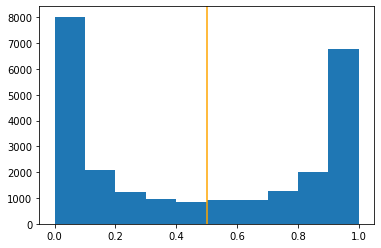

In [333]:
## prediction labels probalities
## orange line threshold
plt.hist(y_pred)
_ = plt.axvline(x=0.5, color='orange')

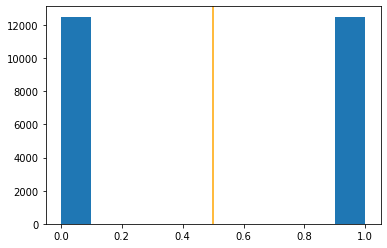

In [334]:
## Actula labels for valid set
plt.hist(y_valid)
_ = plt.axvline(x=0.5, color='orange')

In [341]:
pct_auc = roc_auc_score(y_valid, y_pred) *100.0
print("{:0.2f}".format(pct_auc))

92.88


In [346]:
y_df = pd.DataFrame(list(zip(y_pred, y_valid)))

In [348]:
y_df.head()

,0,1
0,[0.089713216],0
1,[0.98244953],1
2,[0.76073575],1
3,[0.53226334],0
4,[0.99771225],1


In [355]:
### to get rid of the array

y_pred_list =[]

for i in y_pred:
    y_pred_list.append(i[0])

In [359]:
y_df = pd.DataFrame(list(zip(y_pred_list, y_valid)), columns=['y_pred', 'y_valid'])

In [360]:
y_df.head()

,y_pred,y_valid
0,0.089713,0
1,0.982450,1
2,0.760736,1
3,0.532263,0
4,0.997712,1


In [368]:
## let's find actual label is negative but out model predict highly positive
y_df[(y_df.y_valid==0) & (y_df.y_pred >0.9)].head()

,y_pred,y_valid
75,0.913161,0
112,0.940606,0
152,0.928096,0
386,0.972677,0
426,0.902581,0


In [366]:
# let's see the wordings one of them
' '.join(index_word[id] for id in X_train[75])

"found since UNK course well UNK UNK very UNK UNK UNK UNK remain UNK UNK UNK martin heat UNK UNK will UNK joke UNK named UNK average since no UNK UNK white UNK moving without UNK UNK UNK UNK character amateurish sutherland small UNK UNK know if UNK see UNK UNK UNK jet watch superb UNK UNK UNK UNK eyes am UNK UNK player UNK UNK actor amazing UNK when gory UNK forbidden UNK welcome UNK UNK light UNK viewer UNK UNK prison thought up UNK UNK UNK meaning UNK UNK UNK UNK UNK re UNK UNK can't wonder UNK"

In [367]:
' '.join(index_word[id] for id in X_train[112])

'UNK hear watching stars UNK where words UNK need UNK UNK UNK any UNK days school UNK UNK UNK wanted UNK then UNK UNK UNK UNK t UNK because UNK actor UNK UNK very UNK over UNK had UNK UNK UNK UNK UNK v UNK UNK understand lines UNK UNK some blood room UNK UNK UNK lead UNK UNK UNK UNK UNK UNK films human UNK content early heart watch directing UNK because carter amazing UNK UNK UNK over UNK UNK UNK movies UNK UNK UNK UNK UNK UNK UNK UNK UNK mere UNK UNK walk tall UNK takes viewer'

In [369]:
y_df[(y_df.y_valid==1) & (y_df.y_pred <0.1)].head()

,y_pred,y_valid
100,0.098995,1
101,0.029024,1
224,0.061827,1
248,0.083131,1
300,0.070219,1


In [370]:
' '.join(index_word[id] for id in X_train[100])

'UNK UNK discovered put UNK how where showing some UNK put UNK UNK UNK UNK stand UNK james UNK UNK UNK UNK UNK decides friend UNK often UNK whose center UNK its UNK look rex way mean had its UNK french UNK UNK 10 lives UNK UNK beats kills going UNK really UNK written UNK UNK fine other time 1983 feel UNK UNK UNK UNK UNK UNK UNK decent likely add UNK between can UNK UNK than night UNK UNK UNK perfectly looking UNK UNK picking UNK decent sex UNK how amusing ever different UNK UNK might UNK UNK thing'